In [1]:
!pip install torchsummary


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torch.utils.data import DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# 
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_47/2445223466.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
!mkdir output

In [7]:
from torchvision.models import efficientnet_b1,densenet121
model=efficientnet_b1(pretrained=True).features
import torch
import torch.nn as nn
dummy_input = torch.randn(1, 3, 240,240)  # Assuming RGB images of size 224x224

# Forward pass
for i in range(10):    
    output = model[:i](dummy_input)
    print(i,output.shape)
#     print(output.shape)
# print(model)
block1 = nn.Sequential(model)
# print(block1)

0 torch.Size([1, 3, 240, 240])
1 torch.Size([1, 32, 120, 120])
2 torch.Size([1, 16, 120, 120])
3 torch.Size([1, 24, 60, 60])
4 torch.Size([1, 40, 30, 30])
5 torch.Size([1, 80, 15, 15])
6 torch.Size([1, 112, 15, 15])
7 torch.Size([1, 192, 8, 8])
8 torch.Size([1, 320, 8, 8])
9 torch.Size([1, 1280, 8, 8])


In [8]:
import torch
import torch.nn as nn
from torchvision.models import densenet121,efficientnet_b1


#no change in height and width just no of channels changed
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

#increases height and width by factor of 2 
def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )

# As the template for the DenseNet class was used for this cell and updates were made to it
# we forgot to rename the class to EfficientNetB1. However, internally, the pre-trained model used as the encoder is EfficientNetB1 only
class denseUnet(nn.Module):
    
    def __init__(self,encoder,pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = efficientnet_b1(pretrained=True).features # encoder used is EfficientNetB1
        for param in self.encoder.parameters():
          param.requires_grad=False

        self.block1 = nn.Sequential(*self.encoder[:1])#h=112 channel=32
        self.block2 = nn.Sequential(*self.encoder[1:2])#h=112 channel=16
        self.block3 = nn.Sequential(*self.encoder[2:3])#h=56 channel=24
        self.block4 = nn.Sequential(*self.encoder[3:4])#h=28 channel=40
        self.block5 = nn.Sequential(*self.encoder[4:5])#h=14 channel=80
        self.block6 = nn.Sequential(*self.encoder[5:6])#h=14 channel=112
        self.block7 = nn.Sequential(*self.encoder[6:7])#h=8 channel=192
        self.block8 = nn.Sequential(*self.encoder[7:8])#h=8 channel=320
        
        self.bottleneck = nn.Sequential(*self.encoder[8:])#h=8 channel 1280
        self.conv_bottleneck = double_conv(1280, 1280)#h=8 channel=1280
        
        self.up_conv8=nn.ConvTranspose2d(1280,320,kernel_size=1,stride=1,padding=0)#h=8 c=320
        self.conv8 = double_conv(640,320)
        self.up_conv7=nn.ConvTranspose2d(320,192,kernel_size=1,stride=1,padding=0)#h=8 c=192
        self.conv7 = double_conv(192+192, 192)
        self.up_conv6=nn.ConvTranspose2d(192,112,kernel_size=1,stride=2,padding=0)#h=15 c=112
        self.conv6 = double_conv(112+112, 112)
        self.up_conv5=nn.ConvTranspose2d(112,80,kernel_size=1,stride=1,padding=0)#h=15 c=80
        self.conv5 = double_conv(80+80,80)
        self.up_conv4=nn.ConvTranspose2d(80,40,kernel_size=2,stride=2,padding=0)#h=30 c=40
        self.conv4 = double_conv(40+40, 40)
        self.up_conv3=nn.ConvTranspose2d(40,24,kernel_size=2,stride=2,padding=0)#h=60 c=24
        self.conv3 = double_conv(24+24, 24)
        self.up_conv2=nn.ConvTranspose2d(24,16,kernel_size=2,stride=2,padding=0)#h=120 c=16
        self.conv2 = double_conv(16+16, 16)
        self.up_conv1=nn.ConvTranspose2d(16,32,kernel_size=1,stride=1,padding=0)#h=120 c=32
        self.conv1 = double_conv(32+32, 32)
        self.up_conv0=nn.ConvTranspose2d(32,1,kernel_size=2,stride=2,padding=0)#h=240 c=1 output
        
    def forward(self, x1):
        #x..h=256 channels=3
        block1 = self.block1(x1)#h=32 channel=128
        block2 = self.block2(block1)#h=16 c=256
        block3 = self.block3(block2)#h=8 c=512
        block4 = self.block4(block3)#h=8 c=512
        block5 = self.block5(block4)#h=8 c=512
        block6 = self.block6(block5)#h=8 c=512
        block7 = self.block7(block6)#h=8 c=512
        block8 = self.block8(block7)#h=8 c=512
        
        bottleneck=self.bottleneck(block8)
        conv_bottleneck=self.conv_bottleneck(bottleneck)
        
        up_conv8=self.up_conv8(conv_bottleneck)#
        if up_conv8.shape != block8.shape:
            up_conv8 = torch.nn.functional.interpolate(up_conv8, size=block8.shape[2:], mode='bilinear', align_corners=False)
        up_conv8 = torch.cat([up_conv8, block8], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv8 = self.conv8(up_conv8)#h=up_conv,c=up_conv8 channel

        up_conv7=self.up_conv7(up_conv8)
        up_conv7 = torch.cat([up_conv7, block7], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv7 = self.conv7(up_conv7)#h=up_conv,c=up_conv8 channel
        #1.up_conv increases resolution ..
        #2.torch.cat makes skip connection between upconv and corresponding block by concat
        #3.conv7 halves the channels as after concatenation no. of channels was doubled

        up_conv6=self.up_conv6(up_conv7)
        up_conv6 = torch.cat([up_conv6, block6], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv6 = self.conv6(up_conv6)#h=up_conv,c=up_conv8 channel

        up_conv5=self.up_conv5(up_conv6)
        up_conv5 = torch.cat([up_conv5, block5], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv5 = self.conv5(up_conv5)#h=up_conv,c=up_conv8 channel

        up_conv4=self.up_conv4(up_conv5)
        up_conv4 = torch.cat([up_conv4, block4], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv4 = self.conv4(up_conv4)#h=up_conv,c=up_conv8 channel

        up_conv3=self.up_conv3(up_conv4)
        up_conv3 = torch.cat([up_conv3, block3], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv3 = self.conv3(up_conv3)#h=up_conv,c=up_conv8 channel

        up_conv2=self.up_conv2(up_conv3)
        up_conv2 = torch.cat([up_conv2, block2], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv2 = self.conv2(up_conv2)#h=up_conv,c=up_conv8 channel

        up_conv1=self.up_conv1(up_conv2)
        up_conv1 = torch.cat([up_conv1, block1], dim=1)#h=up_conv,c=2*up_conv8 channel
        up_conv1 = self.conv1(up_conv1)#h=up_conv,c=up_conv8 channel

        up_conv0=self.up_conv0(up_conv1)
        
        return up_conv0


def dense_unet(output_dim: int=1, pretrained: bool=False):
    return denseUnet(densenet121, pretrained=pretrained, out_channels=output_dim)

In [10]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.mask = os.listdir(mask_dir)

  def __len__(self):
    return len(self.mask)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.mask[index])

    # img_path = self.image_dir[index]
    # mask_path = self.mask_dir[index]

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    # mask = np.array(Image.open(mask_path))

    mask = (mask//246.0)

    if self.transform != None:
      augmentations = self.transform(image = image,mask = mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image,mask

def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

def check_accuracy(loader,model,accuracy_vals,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))

      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum() + 1e-8)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # index = accu.cpu().data.numpy().argmax()
  print(accu.item())
  accuracy_vals.append(accu.item())

  print(f"Dice score: {dice_score/len(loader)}")
  model.train()

def save_predictions_as_imgs(loader,model,folder,device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [11]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  # train_img,train_mask,val_img,val_mask = distributeData(train_dir,train_maskdir,train_val)

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [12]:
# Dataset (BTP 1 and 2)
# Hyperparameters
# LEARNING_RATE = [1e-4,1e-3,1e-2]
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
train_valid = 0.8
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/input/slumdata/updated_complete_data/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slumdata/updated_complete_data/train_mask'
val_dir = '/kaggle/input/slumdata/updated_complete_data/val_img'
val_mask_dir = '/kaggle/input/slumdata/updated_complete_data/val_mask'
saved_folder = '/kaggle/working/output'

#small data

# TRAIN_IMG_DIR = '/kaggle/input/small-slum-data/small_data/train_img'
# TRAIN_MASK_DIR = '/kaggle/input/small-slum-data/small_data/train_mask'
# val_dir = '/kaggle/input/small-slum-data/small_data/val_img'
# val_mask_dir = '/kaggle/input/small-slum-data/small_data/val_mask'
# saved_folder = '/kaggle/working/output'

In [13]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0
  accuracy_s = []

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
    
      for pred_mask,gt_mask in zip(preds,yy):
        x = np.mean(gt_mask.flatten() == pred_mask.flatten())
        accuracy_s.append(x)

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      # total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  # average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(np.mean(accuracy_s))

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {np.mean(accuracy_s):4f}"
  )


In [15]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()

      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 178/178 [05:48<00:00,  1.96s/it, loss=0.173]


Epoch [1/10], Loss: 0.2027, IoU: 0.4094, Precision: 0.6154, Recall: 0.5395, F1: 0.5696,Accuracy: 0.768677
=> Saving checkpoint
Got 37207825/40896000 with accuracy 90.98157501220703
Average Precision: 0.7447
Accuracy: 0.9098157521517998
Average Dice Score: 0.6864
Average F1 Score: 0.6864
Average IoU Score: 0.5440


100%|██████████| 178/178 [05:52<00:00,  1.98s/it, loss=0.187]


Epoch [2/10], Loss: 0.1756, IoU: 0.5726, Precision: 0.8040, Recall: 0.6692, F1: 0.7265,Accuracy: 0.858393
=> Saving checkpoint
Got 36451875/40896000 with accuracy 89.13311004638672
Average Precision: 0.8227
Accuracy: 0.8913310592723004
Average Dice Score: 0.5902
Average F1 Score: 0.5902
Average IoU Score: 0.4451


100%|██████████| 178/178 [05:54<00:00,  1.99s/it, loss=0.185]


Epoch [3/10], Loss: 0.1676, IoU: 0.5858, Precision: 0.8199, Recall: 0.6779, F1: 0.7375,Accuracy: 0.863963
=> Saving checkpoint
Got 36511979/40896000 with accuracy 89.28007507324219
Average Precision: 0.8122
Accuracy: 0.892800738458529
Average Dice Score: 0.6098
Average F1 Score: 0.6098
Average IoU Score: 0.4646


100%|██████████| 178/178 [05:54<00:00,  1.99s/it, loss=0.137]


Epoch [4/10], Loss: 0.1640, IoU: 0.5916, Precision: 0.8236, Recall: 0.6819, F1: 0.7419,Accuracy: 0.865884
=> Saving checkpoint
Got 36636802/40896000 with accuracy 89.58528900146484
Average Precision: 0.8220
Accuracy: 0.8958529440532081
Average Dice Score: 0.6167
Average F1 Score: 0.6167
Average IoU Score: 0.4724


100%|██████████| 178/178 [05:48<00:00,  1.96s/it, loss=0.149]


Epoch [5/10], Loss: 0.1635, IoU: 0.5932, Precision: 0.8266, Recall: 0.6831, F1: 0.7432,Accuracy: 0.867049
=> Saving checkpoint
Got 37075678/40896000 with accuracy 90.658447265625
Average Precision: 0.7921
Accuracy: 0.9065844581377153
Average Dice Score: 0.6686
Average F1 Score: 0.6686
Average IoU Score: 0.5260


100%|██████████| 178/178 [05:49<00:00,  1.97s/it, loss=0.204]


Epoch [6/10], Loss: 0.1631, IoU: 0.5934, Precision: 0.8295, Recall: 0.6803, F1: 0.7432,Accuracy: 0.867725
=> Saving checkpoint
Got 36723388/40896000 with accuracy 89.7970199584961
Average Precision: 0.7956
Accuracy: 0.8979701682316119
Average Dice Score: 0.6294
Average F1 Score: 0.6294
Average IoU Score: 0.4859


100%|██████████| 178/178 [05:56<00:00,  2.00s/it, loss=0.18] 


Epoch [7/10], Loss: 0.1621, IoU: 0.5994, Precision: 0.8349, Recall: 0.6835, F1: 0.7480,Accuracy: 0.869867
=> Saving checkpoint
Got 36288900/40896000 with accuracy 88.7345962524414
Average Precision: 0.8222
Accuracy: 0.8873459507042254
Average Dice Score: 0.5728
Average F1 Score: 0.5728
Average IoU Score: 0.4309


100%|██████████| 178/178 [05:49<00:00,  1.96s/it, loss=0.149]


Epoch [8/10], Loss: 0.1625, IoU: 0.5931, Precision: 0.8282, Recall: 0.6833, F1: 0.7429,Accuracy: 0.867020
=> Saving checkpoint
Got 36606665/40896000 with accuracy 89.51160430908203
Average Precision: 0.8228
Accuracy: 0.8951160260172143
Average Dice Score: 0.6067
Average F1 Score: 0.6067
Average IoU Score: 0.4640


100%|██████████| 178/178 [05:50<00:00,  1.97s/it, loss=0.14] 


Epoch [9/10], Loss: 0.1621, IoU: 0.5951, Precision: 0.8324, Recall: 0.6808, F1: 0.7448,Accuracy: 0.868324
=> Saving checkpoint
Got 36618752/40896000 with accuracy 89.5411605834961
Average Precision: 0.8147
Accuracy: 0.8954115805946791
Average Dice Score: 0.6114
Average F1 Score: 0.6114
Average IoU Score: 0.4689


100%|██████████| 178/178 [05:46<00:00,  1.94s/it, loss=0.147]


Epoch [10/10], Loss: 0.1622, IoU: 0.5941, Precision: 0.8304, Recall: 0.6824, F1: 0.7441,Accuracy: 0.867571
=> Saving checkpoint
Got 36842538/40896000 with accuracy 90.08836364746094
Average Precision: 0.8163
Accuracy: 0.9008836561032865
Average Dice Score: 0.6362
Average F1 Score: 0.6362
Average IoU Score: 0.4928
Training finished
loss_train : [0.2026948824190022, 0.1756419643257441, 0.16760021908564515, 0.1640484934944785, 0.1635350383232149, 0.1631302743982733, 0.16205273903487774, 0.16250083294142498, 0.16206768071383573, 0.16221291555112669]
iou_train : [0.4094184319143491, 0.572557826973267, 0.5857850504202076, 0.5915691989949515, 0.5932434089404796, 0.5934062622573721, 0.5994075685316268, 0.5930939361012015, 0.5950582226325334, 0.5941120899798362]
precision_train : [0.6154323288842766, 0.8039889645978098, 0.81986496816118, 0.8235804654062461, 0.826602067421197, 0.8295454272503852, 0.8349192229865209, 0.8281627801715957, 0.8324278349222171, 0.8303505287406135]
recall_train : [0.53

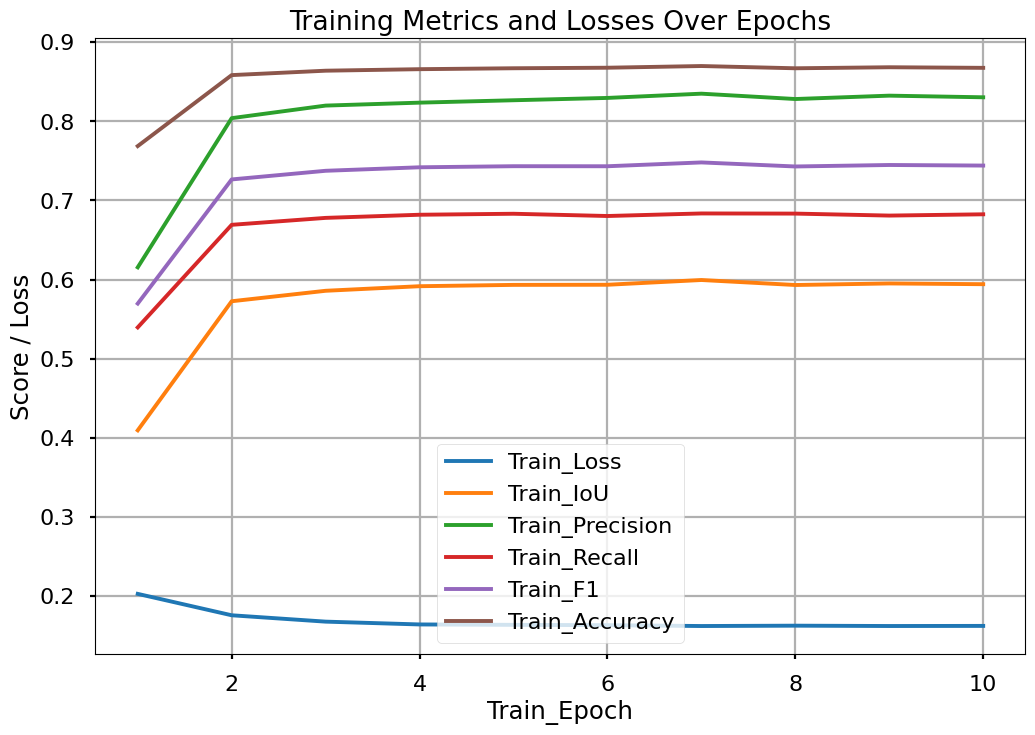

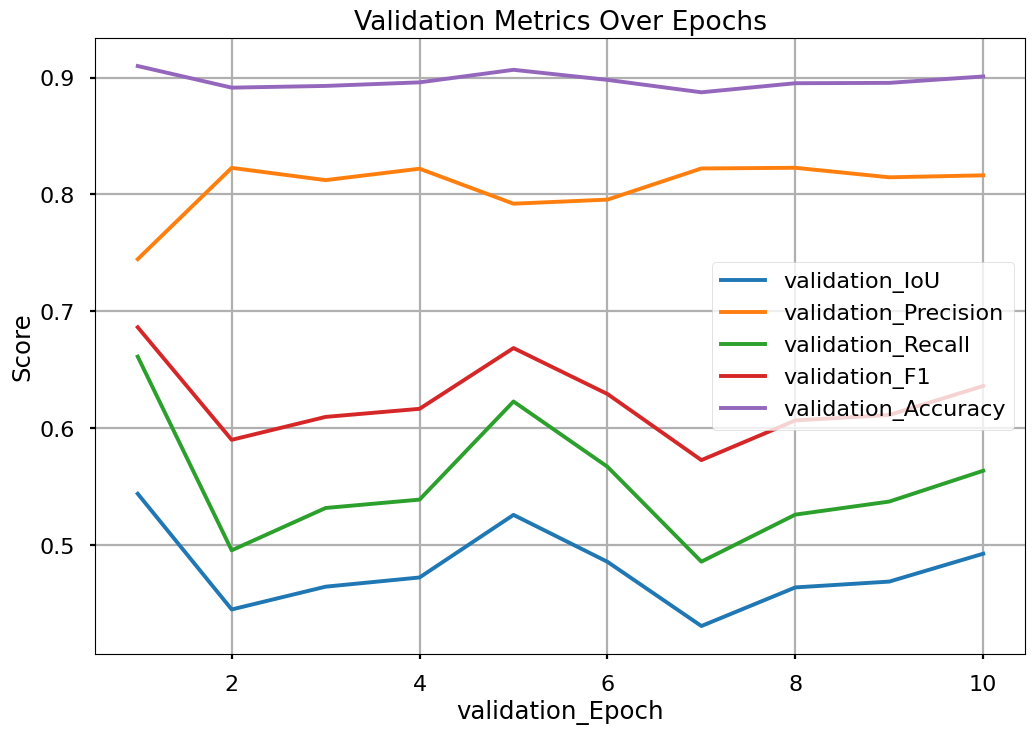

In [16]:
from torch.optim.lr_scheduler import StepLR
def main():
  # data augumentation:
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.1),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 255.0
      ),
      ToTensorV2(),
    ],is_check_shapes = False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 255.0
    ),
    ToTensorV2(),
  ],is_check_shapes = False
  )

  # model instance:
  model = dense_unet().to(DEVICE)

  # defining loss:
  loss_fn = FocalLoss()

  #defining optimizer:
  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # setting loaders:
  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  # if LOAD_MODEL :
  #   load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  # check_accuracy(val_loader,model,device = DEVICE)

  scaler = torch.cuda.amp.GradScaler()


# Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

 # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

 # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = DEVICE)
    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder = saved_folder,device = DEVICE
    )
  print("Training finished")

  # Plot metrics and losses
  # Plot for Training dataset
  print(f'loss_train : {loss_train}')
  print(f'iou_train : {iou_train}')
  print(f'precision_train : {precision_train}')
  print(f'recall_train : {recall_train}')
  print(f'f1_train : {f1_train}')
  print(f'Accuracy_train : {accuracy_train}')

  
  print(f'Validation result')
  print(f'f1_val: {f1_val}')
  print(f'dice_scores : {dice_scores}')
  print(f'iou_scores : {iou_scores}')
  print(f'precision_scores : {precision_scores}')
  print(f'recall_scores : {recall_scores}')
  print(f'Accuracy_scores : {accuracy_vals}')

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, dice_scores, label='validation_F1')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

#   summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

#   func(NUM_EPOCHS,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals)

if __name__ == "__main__":
  main()